# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [ ]:
def load_data(data_dir='data/raw'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    
    signal_files = {
        'HR': 'heart_rate',
        'EDA': 'eda',
        'TEMP': 'temperature',
    }

    all_data = []

    for subject in sorted(os.listdir(data_dir)):
        subject_path = os.path.join(data_dir, subject)
        if not os.path.isdir(subject_path) or not subject.startswith('S'):
            continue

        for session in ['Midterm 1', 'Midterm 2', 'Final']:
            session_path = os.path.join(subject_path, session)
            if not os.path.isdir(session_path):
                continue

            info_path = os.path.join(session_path, 'info.txt')
            if not os.path.exists(info_path):
                print(f"Missing info.txt for {subject} {session}")
                continue

            sampling_rates = {}
            with open(info_path, 'r') as f:
                for line in f:
                    parts = line.strip().split(':')
                    if len(parts) == 2:
                        name = parts[0].strip().upper()
                        try:
                            sampling_rates[name] = float(parts[1].strip().split()[0])
                        except:
                            continue

            signal_dfs = {}
            for file_key, col_name in signal_files.items():
                file_path = os.path.join(session_path, f"{file_key}.csv")
                if not os.path.exists(file_path):
                    continue

                try:
                    df = pd.read_csv(file_path, header=None)
                except pd.errors.EmptyDataError:
                    continue

                if df.empty or len(df) < 2:
                    continue

                start_time_unix = df.iloc[0, 0]  # Initial timestamp
                sample_rate = df.iloc[1, 0]      # Sample rate 

                # since the first two rows are info an data starts from the third row 
                data = df.iloc[2:].reset_index(drop=True)

                if file_key == 'ACC':
                    # ACC has 3 columns (x, y, z)
                    data.columns = ['acc_x', 'acc_y', 'acc_z']
                elif file_key == 'IBI':
                    # IBI has two columns: time and duration
                    data.columns = ['ibi_time', 'ibi_duration']
                else:
                    # Other signals like HR, EDA, TEMP, BVP
                    data.columns = [col_name]

                # Handle timestamps for each signal
                timestamps = pd.to_datetime(start_time_unix, unit='s') + pd.to_timedelta(data.index / sample_rate, unit='s')
                data['timestamp'] = timestamps

                signal_dfs[col_name] = data

            if not signal_dfs:
                continue

            merged = None
            for df in signal_dfs.values():
                if merged is None:
                    merged = df
                else:
                    merged = pd.merge_asof(merged.sort_values('timestamp'),
                                           df.sort_values('timestamp'),
                                           on='timestamp')

            merged['subject_id'] = subject
            merged['session'] = session
            all_data.append(merged)

    if not all_data:
        return pd.DataFrame(columns=[
            'timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session'
        ])

    full_df = pd.concat(all_data, ignore_index=True)

    cols = ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    for col in cols:
        if col not in full_df.columns:
            full_df[col] = np.nan

    return full_df[cols]
    pass

## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import zscore

def preprocess_data(data, output_dir='data/processed', file_format='csv'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    # Handle missing values 
    data_imputed = data.copy()
    
    # Impute missing values for all columns 
    for column in data_imputed.columns:
        if data_imputed[column].isnull().sum() > 0:
            data_imputed[column].fillna(data_imputed[column].mean(), inplace=True)

    # Resample the data to regular intervals 
    data_imputed.set_index('timestamp', inplace=True)
    data_resampled = data_imputed.groupby(['subject_id', 'session']).resample('1T').mean().reset_index()

    # Remove outliers using Z-score
    numeric_columns = data_resampled.select_dtypes(include=[np.number]).columns
    for column in numeric_columns:
        # Calculate Z-scores and filter out rows with Z-scores greater than the threshold
        z_scores = zscore(data_resampled[column])
        data_resampled = data_resampled[np.abs(z_scores) <= 3.5]

    subjects = data_resampled['subject_id'].unique()
    
    for subject in subjects:
        subject_data = data_resampled[data_resampled['subject_id'] == subject]
        
        # Define file path
        file_path = os.path.join(output_dir, f'{subject}_processed.{file_format}')
        
        # Save the data based on the desired format
        if file_format == 'csv':
            subject_data.to_csv(file_path, index=False)
        elif file_format == 'parquet':
            subject_data.to_parquet(file_path, index=False)
        elif file_format == 'feather':
            subject_data.reset_index(drop=True, inplace=True)
            subject_data.to_feather(file_path)
        else:
            raise ValueError(f"Unsupported file format: {file_format}")
    


In [ ]:
loaded_df = load_data('data')
preprocess_data(loaded_df, output_dir='data/processed')

/tmp/ipykernel_1685/3552100950.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_resampled = data_imputed.groupby(['subject_id', 'session']).resample('1T').mean().reset_index()


Data processed and saved to data/processed


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [10]:
def plot_physiological_signals(data_dir, subject_id, session, output_dir='plots', file_format='csv'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    os.makedirs(output_dir, exist_ok=True)

    # Construct the file path 
    file_path = os.path.join(data_dir, f'{subject_id}_processed.{file_format}')
    
    # Load the data 
    if file_format == 'csv':
        subject_data = pd.read_csv(file_path)
    elif file_format == 'parquet':
        subject_data = pd.read_parquet(file_path)
    elif file_format == 'feather':
        subject_data = pd.read_feather(file_path)
    else:
        raise ValueError(f"Unsupported file format: {file_format}")
    
    # Filter the data 
    subject_data_session = subject_data[subject_data['session'] == session]
    
    
    # Create a figure and a set of subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # Plot each physiological signal 
    axes[0].plot(subject_data_session['timestamp'], subject_data_session['heart_rate'], color='b')
    axes[0].set_title(f'Subject {subject_id} - {session} - Heart Rate')
    axes[0].set_ylabel('Heart Rate (bpm)')
    
    axes[1].plot(subject_data_session['timestamp'], subject_data_session['eda'], color='g')
    axes[1].set_title(f'Subject {subject_id} - {session} - EDA')
    axes[1].set_ylabel('EDA (uS)')
    
    axes[2].plot(subject_data_session['timestamp'], subject_data_session['temperature'], color='r')
    axes[2].set_title(f'Subject {subject_id} - {session} - Temperature')
    axes[2].set_ylabel('Temperature (°C)')
    

    axes[2].set_xlabel('Timestamp')
    plt.xticks(rotation=45)
    
    # Save the figure as a PNG file
    file_output_path = os.path.join(output_dir, f'{subject_id}_{session}_signals.png')
    plt.tight_layout()
    plt.savefig(file_output_path)
    
    return fig

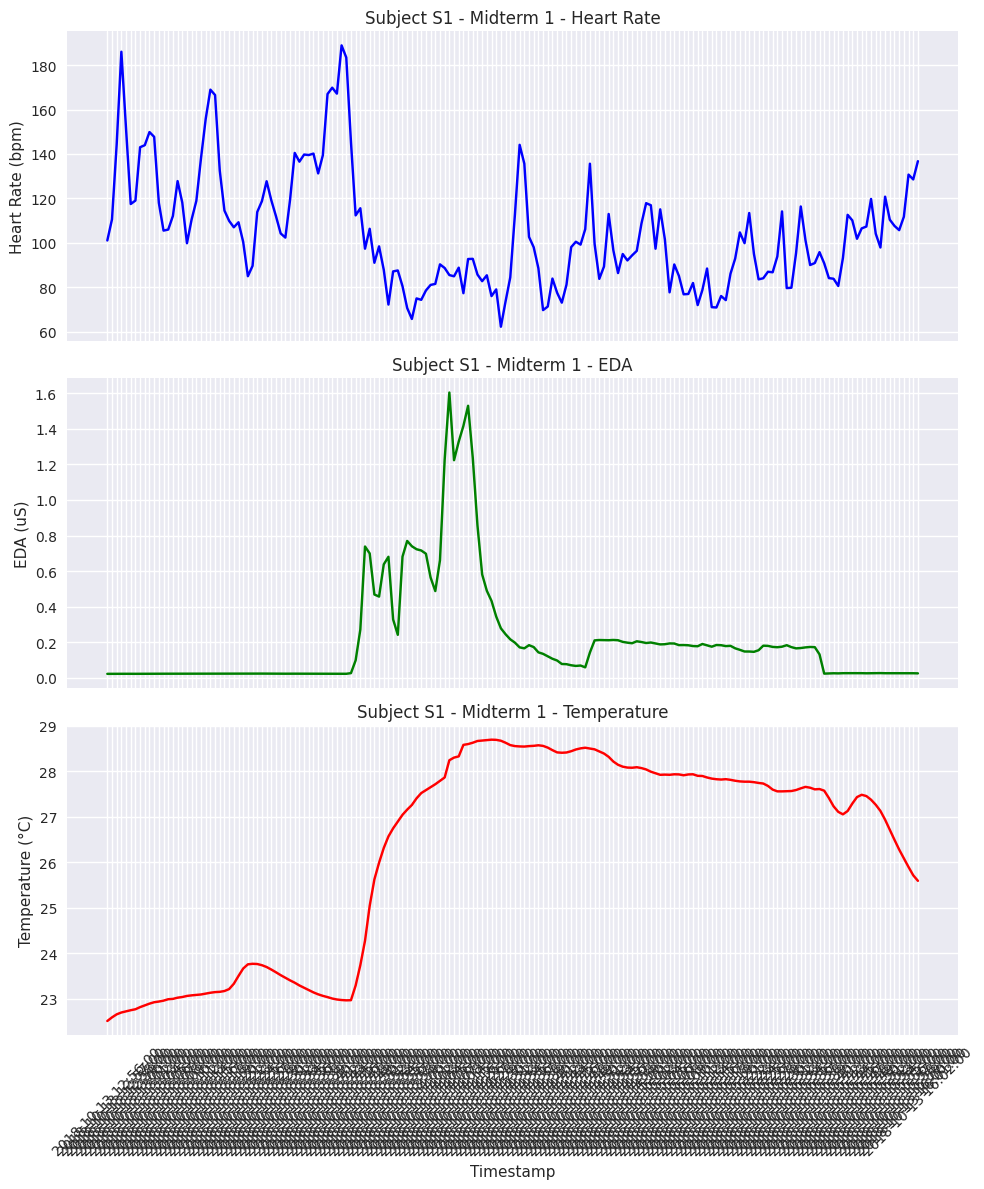

In [12]:
fig = plot_physiological_signals(data_dir='data/processed', subject_id='S1', session='Midterm 1', output_dir='plots', file_format='csv')
plt.show()
